## Import Dependencies

In [80]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import warnings
import folium
from qbstyles import mpl_style
mpl_style(dark = True)
warnings.filterwarnings('ignore')
import os
os.environ["OMP_NUM_THREADS"] = '1'

## Load and process the data

In [81]:
df1=pd.read_csv('Gym_Toronto/final_data.csv')  ## The data processed in the previous step
df1=df1.set_index('Unnamed: 0')

In [82]:
gyms = pd.read_csv("Gym_Toronto/Toronto_data.csv")     ## data about gyms 

In [83]:
excel_url = 'https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/7e038ff9-b616-4070-9753-6f493b2cdbb0/resource/448f9470-e1e3-4eeb-b88c-6106e6d426da/download/wellbeing-toronto-safety.xlsx'
xls = pd.ExcelFile(excel_url)
crime_rate = pd.read_excel(xls,sheet_name=None)
crime_rate=crime_rate['RawData-Ref Period 2011'].set_index('Unnamed: 0').sort_index()['Unnamed: 14']

In [84]:
df1 = df1.merge(crime_rate,how='left',left_index=True,right_index=True).rename(columns ={'Unnamed: 14':'total_crime'})
df1

,park_size,percent_park,gym_number,area_per_gym,avg_tax,customer_percentage,high_inc_percent,population,Area,total_crime
Unnamed: 0,,,,,,,,,,
Agincourt North,54.226448,6.673952,1.0,812.508771,4795.0,35.307820,8.870293,29113.0,812.508771,296
Agincourt South-Malvern West,53.624921,6.089371,8.0,110.078948,5102.0,40.020555,10.432034,23757.0,880.631588,380
Alderwood,70.733276,12.739049,4.0,138.811928,7895.0,36.808081,19.131529,12054.0,555.247713,189
Annex,23.426225,7.519823,34.0,9.162537,30496.0,48.226726,31.513141,30526.0,311.526269,604
Avondale,15.169528,13.150522,6.0,19.225508,NaN,NaN,NaN,NaN,115.353051,NaN
...,...,...,...,...,...,...,...,...,...,...
Yonge-Doris,2.653247,5.029623,5.0,10.550483,NaN,NaN,NaN,NaN,52.752417,NaN
Yonge-Eglinton,27.466685,14.898643,23.0,8.015520,20794.0,45.469729,34.006734,11817.0,184.356952,229
Yonge-St.Clair,2.765579,2.132339,7.0,18.528136,27170.0,40.445982,36.521739,12528.0,129.696954,111


In [85]:
df1['park_per_person'] = df1.park_size / df1.population        ## New column - It is explained below
df1['gym_per_customer'] = df1.gym_number / (df1.population* df1.customer_percentage )      ## New column - It is explained below
df1['crime_rate'] = df1.total_crime/df1.population             ## New column - It is explained below
 

df1=df1.drop(columns= ['park_size','gym_number','population', 'Area','customer_percentage','high_inc_percent',
                     'percent_park','area_per_gym','total_crime'])    ## Drop unnecessary columns

In [86]:
df1.dropna(inplace=True)   ## Drop rows with null values
def scale(df1):                       ## Define a function for scaling the data
    return df1.apply(lambda x: ((x - x.min()) / (x.max() - x.min())) * 9 + 1)   ## Scale the data min = 1 ; max = 10
df = scale(df1)

    
df.crime_rate = df.crime_rate.astype('float')                        ## convert the column into float
df

,avg_tax,park_per_person,gym_per_customer,crime_rate
Unnamed: 0,,,,
Agincourt North,1.230199,1.435564,1.011573,1.851496
Agincourt South-Malvern West,1.280427,1.530155,2.494647,3.092777
Alderwood,1.737388,2.395703,2.614459,3.025507
Annex,5.435129,1.173033,5.420558,3.900233
Banbury-Don Mills,2.796761,2.915713,4.281694,1.831633
...,...,...,...,...
Wychwood,2.337018,1.235858,4.099076,2.951524
Yonge-Eglinton,3.847789,1.546242,9.348804,3.813430
Yonge-St.Clair,4.890963,1.041991,3.570955,1.573097


## Feature Analysis and Expectations

- crime_rate : This feature is pretty straight forward it shows **the number of crimes committed per person** in the neighborhood; people would not like to be in an unsafe area. An enterpreneur should always take this into consideration. This value should be as low as possible for an appropriate investment area.


- avg_tax : **Average tax amount collected per person** in a neighborhood. It gives us an idea about the economic wellbeing of the residents in the neighborhood. It can be assumed that the neighborhood is wealthy and can afford for a gym subscription. It is important because having a gym subscription is not a fundemental expenditure.

- park_per_person : **The size(in km squared) of the area per person.** This feature may be used to determine the level of how much infrastructure is available if a sport enthusiast would like to use them. If it is enough, people could choose to continue their routine without going to gyms. This is a competition for gyms.


- gym_per_customer : Basically **the number of gyms per customer** is shown with this feature. People who are between 15 and 45 are referred as customer. Lower numbers might indicate high demand which can be taken as a business opportunity.


## Modeling

In [87]:
values = []                                      ## Empty list to store outcomes
for cluster in range(1,15):                     ## Loop in a range
    model = KMeans(n_clusters = cluster)          ## Call the model with different hyperparameter values
    model.fit(df)                                 
    values.append(model.inertia_)                 ## Fit and get inertia for each n_cluster hyperparameter

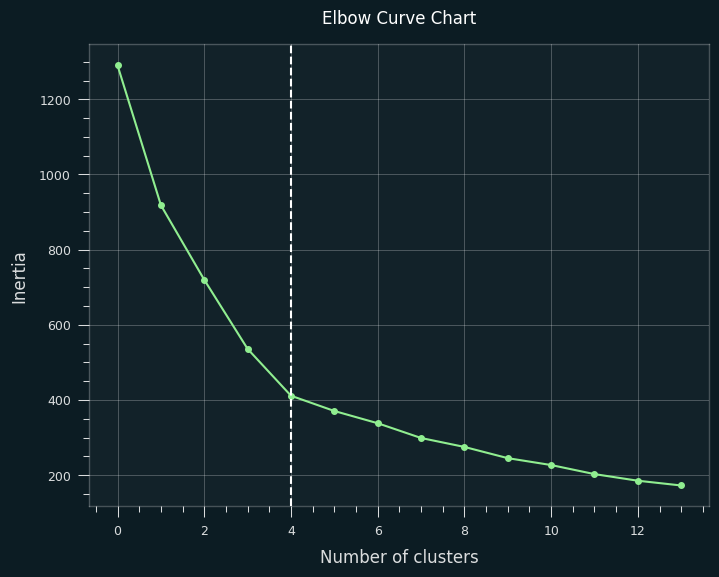

In [103]:
plt.figure(figsize=(8,6))                             
plt.title('Elbow Curve Chart')                   
plt.xlabel('Number of clusters')                       
plt.ylabel('Inertia')
plt.plot(np.arange(14),values,marker='o', color = 'lightgreen')
plt.axvline(x = 4, color = 'white' ,linestyle = 'dashed', label = 'axvline - full height')
plt.show()                                     ## Plot a chart that shows change in inertia as n_cluster value varies.


The elbow curve shows that 4 is good for cluster number. The point where the angle starts stabilizing is chosen as the optimal n_clusters value.

In [89]:
model = KMeans(n_clusters = 4)           ## Call the model and pass in the optimal value.
model.fit(df)

KMeans(n_clusters=4)

In [90]:
preds = model.predict(df)                 ## Make predictions    
df['preds'] = preds                         ## Add the predictions to the data frame
df

,avg_tax,park_per_person,gym_per_customer,crime_rate,preds
Unnamed: 0,,,,,
Agincourt North,1.230199,1.435564,1.011573,1.851496,0
Agincourt South-Malvern West,1.280427,1.530155,2.494647,3.092777,0
Alderwood,1.737388,2.395703,2.614459,3.025507,0
Annex,5.435129,1.173033,5.420558,3.900233,1
Banbury-Don Mills,2.796761,2.915713,4.281694,1.831633,0
...,...,...,...,...,...
Wychwood,2.337018,1.235858,4.099076,2.951524,0
Yonge-Eglinton,3.847789,1.546242,9.348804,3.813430,2
Yonge-St.Clair,4.890963,1.041991,3.570955,1.573097,1


## Visualized Distribution of Instances 

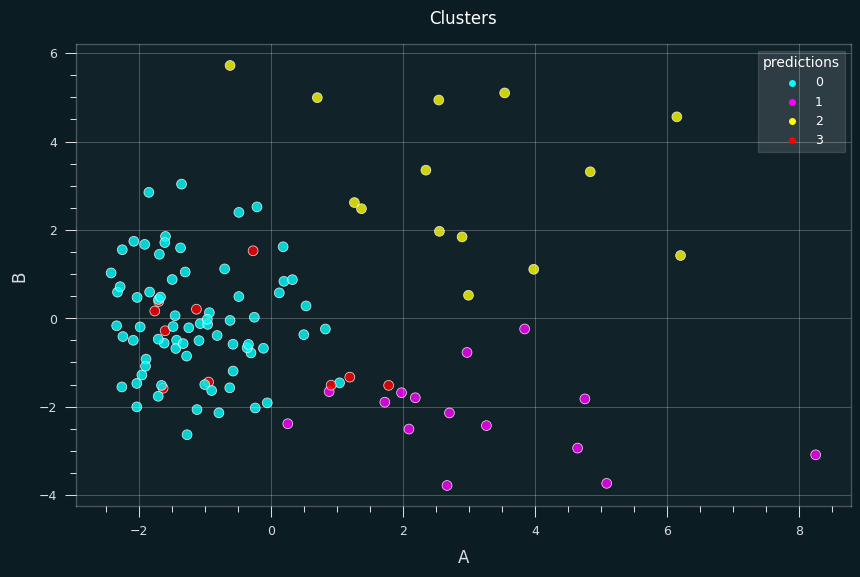

In [91]:
pca = PCA(2)                               ## Call PCA for dimension reduction 
viz_df=pca.fit_transform(df)              ## Reduce the dimension number to be able to visualize the data in 2D
viz_df = pd.DataFrame(viz_df)
viz_df.columns = ["A","B"]
viz_df['predictions'] = df.preds.values


plt.figure(figsize=(10,6))
plt.title('Clusters')
#plt.style.use('seaborn-dark')             
colors = ['cyan','magenta','yellow','red']
sns.scatterplot(data = viz_df, x= "A", y = "B", hue = "predictions",palette = colors ,alpha=0.8,s=50)
plt.show()


In [92]:
import ipywidgets as widgets
output1 = widgets.Output()                         ## Create output object
output2 = widgets.Output()
output3 = widgets.Output()
output4 = widgets.Output()


with output1:                                  ## Pass in the item to be presented
    display(df[df.preds==0].describe()) 

with output2:
    display(df[df.preds==1].describe())

with output3:
    display(df[df.preds==2].describe())

with output4:
    display(df[df.preds==3].describe())

tab_contents = [output1, output2, output3,output4]        ## list the items
tab = widgets.Tab()                                     ## create tab object
tab.children = tab_contents                               ## assign items to tabs
tab.set_title(0, 'Cluster 0')                            ##  title
tab.set_title(1, 'Cluster 1')
tab.set_title(2, 'Cluster 2')
tab.set_title(3, 'Cluster 3')

tab

## Interpretation of Clusters

I create a loop to make a basic calculation for selecting the best cluster for investment. After I created tables of descriptive analysis, I extract the mean values for each column for each neighborhood and simply sum all the values.

Some values are better when they are lower like crime rate. Therefore, I first substract such values from the maximum value (which is 10 as determined before in the scaling part) and then add them to the total for the best calculation. 


In [93]:
clusters = {}
for t in range(4):            ## number of clusters
    row = []                   ## an empty list to store values
    for i in df.columns[0:4]:         ## Loop through the columns
        val = df[df.preds==t].describe()[i][1]            ## Get the mean values for the current column
        row.append(val)                              ## Store them into the list created above
    clusters[f'cluster_{t}'] = (row[0])  +  (10 - row[1] ) + (10 - row[2]) + (10 - row[3])      ## Sum the values and store them
cluster_df =pd.DataFrame(columns = ['value'], index = clusters.keys(), data = clusters.values())     ## Create a dataframe
cluster_df=cluster_df.sort_values('value', ascending=False)            ## sort values
cluster_df.value = cluster_df.value - 15                           ## lower the values for better visualization


In [94]:
cluster_number  = int(str(cluster_df.index[0])[-1])      ## Extracted the number of the best cluster for formatting

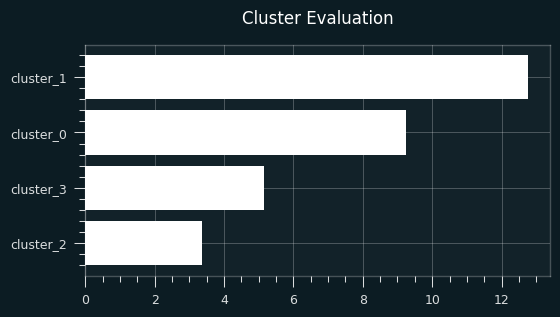

In [95]:
plt.figure(figsize=(6,3))
plt.title('Cluster Evaluation')
plt.barh(y = cluster_df.index[::-1], width=cluster_df.value[::-1],color = 'white')
plt.show()

## Cluster Analysis

In [96]:
print(f'- As we look at the descriptive statistics of each clusters, we can conclude that the cluster {cluster_number} is the best cluster for a new gym enterprise.\n')

print(f'- Neighborhoods that are in the cluster {cluster_number} show the lowest crime rate among others. This is a great factor for a business investor. Safety comes first for any human being so it should be guaranteed before anything.\n')  

print(f'- Neigborhoods with high profit potential are not too saturated with gyms. There is still market share available to claim. We can see the saturation with gym_per_customer column.\n' )

print(f'- Another feature of a neighborhood with potential is not having enough outdoor/free/green spaces like parks for people. This would push people to have gym subscriptions. Conversely, having substitute infrastructure to gyms create an invisible competition for enterpreneurs.\n') 

print(f'- The neighborhoods in cluster {cluster_number} are not the wealthiest ones but they are still above average, which is enough to make this cluster the best when combined with other features.\n') 

- As we look at the descriptive statistics of each clusters, we can conclude that the cluster 1 is the best cluster for a new gym enterprise.

- Neighborhoods that are in the cluster 1 show the lowest crime rate among others. This is a great factor for a business investor. Safety comes first for any human being so it should be guaranteed before anything.

- Neigborhoods with high profit potential are not too saturated with gyms. There is still market share available to claim. We can see the saturation with gym_per_customer column.

- Another feature of a neighborhood with potential is not having enough outdoor/free/green spaces like parks for people. This would push people to have gym subscriptions. Conversely, having substitute infrastructure to gyms create an invisible competition for enterpreneurs.

- The neighborhoods in cluster 1 are not the wealthiest ones but they are still above average, which is enough to make this cluster the best when combined with other features.



## The best neighborhoods for investment

In [97]:
df1['preds'] = df.preds 
df1[df1.preds==cluster_number]

,avg_tax,park_per_person,gym_per_customer,crime_rate,preds
Unnamed: 0,,,,,
Annex,30496.0,0.000767,0.000023,0.019786,1
Bedford Park-Nortown,32139.0,0.000639,0.000010,0.016139,1
Casa Loma,40970.0,0.003330,0.000010,0.008297,1
Edenbridge-Humber Valley,25291.0,0.004083,0.000004,0.011909,1
Forest Hill North,20488.0,0.001109,0.000010,0.012104,1
Forest Hill South,49228.0,0.001986,0.000020,0.008572,1
Kingsway South,36696.0,0.002997,0.000026,0.012944,1
Lawrence Park North,26958.0,0.000581,0.000018,0.009653,1
Lawrence Park South,47166.0,0.001859,0.000019,0.012583,1


## Feature Importance

I utilize another model to get the feature importance levels of my cluster model. 

In [98]:
from sklearn.ensemble import RandomForestClassifier
model1 = RandomForestClassifier()
model1.fit(df.drop(columns=['preds']),df.preds)

RandomForestClassifier()

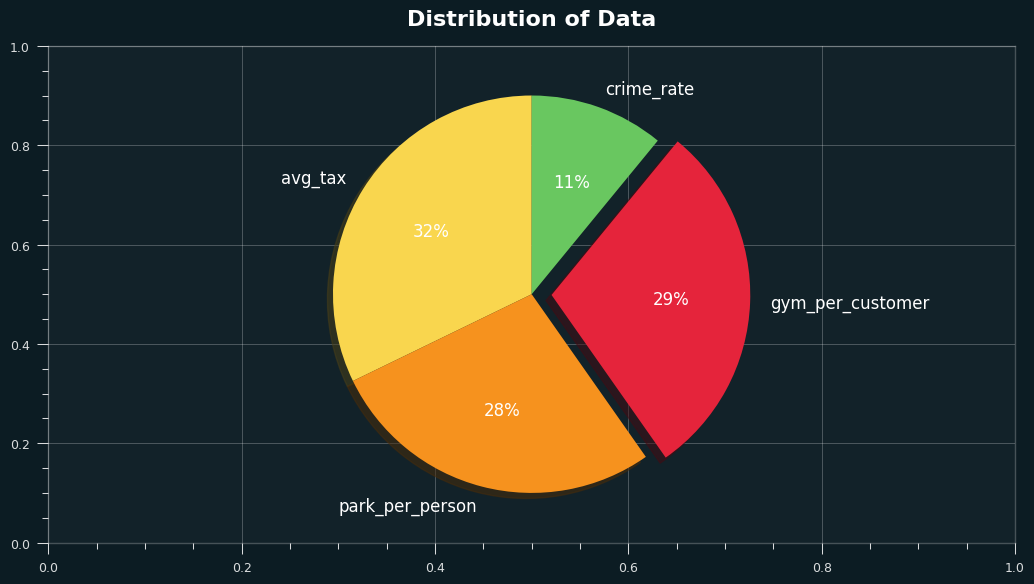

In [99]:
feat=pd.DataFrame(data = model1.feature_importances_, index= model1.feature_names_in_, columns =['Feature_importance'])
# declaring data
data = feat.Feature_importance
keys = feat.index
  
colors = ['#F9D64E', '#F6921E', '#E5243B', '#69C760']
explode = (0, 0, 0.1, 0)  # Explode the 3rd slice (Red)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Customize the chart
ax.pie(data, labels=keys, colors=colors, explode=explode, autopct='%.0f%%',
       shadow=True, startangle=90, textprops={'fontsize': 12, 'color': 'white'})

# Add a title
ax.set_title("Distribution of Data", fontsize=16, fontweight='bold')
ax.set_aspect('equal')

# Remove unnecessary spines and ticks
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='both', length=0)

# Adjust layout to fit the labels properly
plt.tight_layout()

# Display the chart
plt.show()

## MAPPING 

I define a function to show gym locations. 

In [100]:
def mapp(data):
    coordi= []
    for x,y in zip(data.lat,data.lon):
        coordi.append([x,y])
    
    mapit = folium.Map( location=coordi[0], zoom_start=6 )
    folium.TileLayer('cartodbpositron').add_to(mapit)
    for coord in coordi:
        
        folium.Marker( location=[ coord[0], coord[1] ], fill_color='#43d9de', radius=5 ).add_to( mapit )

    mapit.save('map.html')
    
    return mapit

In [101]:
gyms.District=[x.strip() for x in gyms.District.values]     ##  Clean the whitespaces in the neighborhood names 
clstr1=gyms[gyms.District.isin(df[df.preds==cluster_number].index)]  ## Filter the gyms which are located within the cluster 1 neighborhoods

**This map only shows the gyms located in the best neighborhood cluster for investment.**

In [102]:
mapp(clstr1)        